In [1]:
import pandas as pd

In [2]:
path = './data/18-10-27_names.csv'

In [3]:
df = pd.read_csv(path, sep='\\', encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 538161: expected 12 fields, saw 26\n'


In [4]:
df = df.rename(columns={"frame.time_relative": "time",
                        "_ws.col.Protocol": "protocol",
                        "frame.len": "len",
                        "_ws.col.Info": "info"})

In [5]:
df.head()

,time,eth.src,eth.src_resolved,eth.dst,eth.dst_resolved,ip.src,ip.src_host,ip.dst,ip.dst_host,protocol,len,info
0,0.000000,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,e0:76:d0:3f:00:ae,AMPAKTec_3f:00:ae,54.85.78.92,54.85.78.92,192.168.1.216,192.168.1.216,TLSv1.2,233,Application Data
1,0.136005,e0:76:d0:3f:00:ae,AMPAKTec_3f:00:ae,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.216,192.168.1.216,54.85.78.92,54.85.78.92,TLSv1.2,196,Application Data
2,0.179176,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,174.129.217.97,174.129.217.97,TCP,66,"4998 â 3478 [FIN, ACK] Seq=1 Ack=1 Win=2920 ..."
3,0.181720,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,192.168.1.1,192.168.1.1,DNS,68,Standard query 0x074d A xbcs.net
4,0.183805,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,84,Standard query response 0x074d A xbcs.net A 18...


<AxesSubplot:>

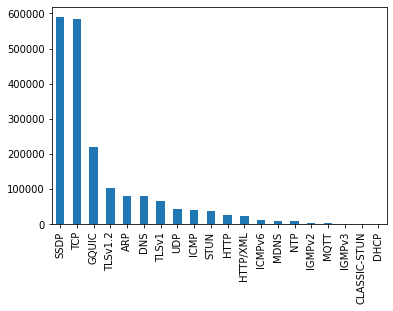

In [6]:
df['protocol'].value_counts()[:20].plot(kind='bar')

In [7]:
ip_sources = df['ip.src'].value_counts()
len(ip_sources)

381

<AxesSubplot:>

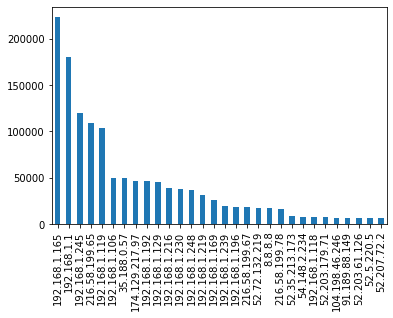

In [8]:
ip_sources[:30].plot(kind='bar')

In [9]:
ip_destinations = df['ip.dst'].value_counts()
len(ip_destinations)

396

<AxesSubplot:>

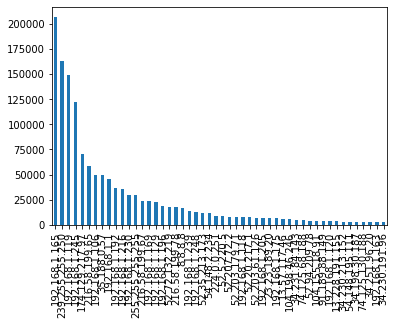

In [10]:
ip_destinations[:50].plot(kind='bar')

In [11]:
len(df['eth.src'].value_counts())

28

<AxesSubplot:>

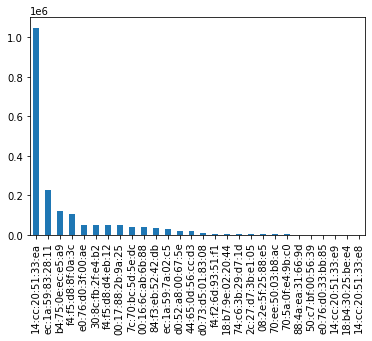

In [12]:
df['eth.src'].value_counts()[:50].plot(kind='bar')

<AxesSubplot:>

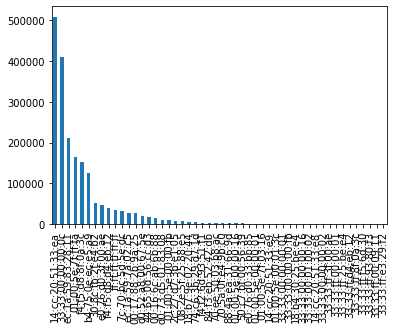

In [13]:
df['eth.dst'].value_counts()[:50].plot(kind='bar')

<AxesSubplot:>

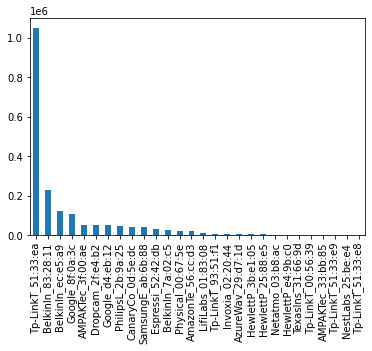

In [14]:
df['eth.src_resolved'].value_counts()[:50].plot(kind='bar')

<AxesSubplot:>

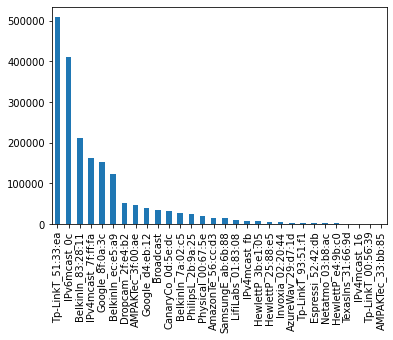

In [15]:
df['eth.dst_resolved'].value_counts()[:30].plot(kind='bar')

In [16]:
df['ip.dst'].value_counts()

192.168.1.165      206881
239.255.255.250    163745
192.168.1.119      149384
192.168.1.245      121936
174.129.217.97      70157
                    ...  
212.83.145.32           1
85.114.128.137          1
106.10.186.201          1
139.162.12.72           1
150.101.178.79          1
Name: ip.dst, Length: 396, dtype: int64

Next: check the packet that raised a warning when running tshark (1479336)

mac name resolution

### Packets that raise a warning when running tshark

In [17]:
df.iloc[1479335]

time                          65770.7
eth.src             00:17:88:2b:9a:25
eth.src_resolved    PhilipsL_2b:9a:25
eth.dst             ec:1a:59:83:28:11
eth.dst_resolved    BelkinIn_83:28:11
ip.src                  192.168.1.129
ip.src_host             192.168.1.129
ip.dst                  192.168.1.165
ip.dst_host             192.168.1.165
protocol                         SSDP
len                               339
info                 HTTP/1.1 200 OK 
Name: 1479335, dtype: object

In [18]:
df.iloc[1479335]['info']

'HTTP/1.1 200 OK '

Seems like the info column is too long (>500)

### Now we try to split the dataset based on IP addresses of the IoT devices

#### Top 30 source private IP addresses

<AxesSubplot:>

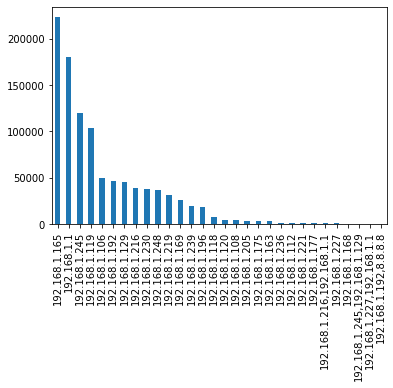

In [19]:
ip_sources[ip_sources.index.str.startswith('192.168.')][:30].plot(kind='bar')

#### Top 30 source public IP addresses

<AxesSubplot:>

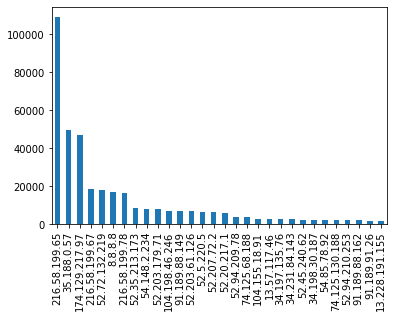

In [20]:
ip_sources[~ ip_sources.index.str.startswith('192.168.')][:30].plot(kind='bar')

#### 192.168.1.118 is a random IoT device, try to understand with who it communicates in the LAN

In [21]:
df[df['ip.src'] == '192.168.1.118']['eth.src_resolved'].value_counts()

LifiLabs_01:83:08    8011
Name: eth.src_resolved, dtype: int64

192.168.1.118 is probably a LIFX smart lamp (its MAC address is from Lifilabs).

In [22]:
df[df['ip.dst'] == '192.168.1.118']['eth.src_resolved'].value_counts()

Tp-LinkT_51:33:ea    7905
Name: eth.src_resolved, dtype: int64

It looks like the device with MAC 51:33:ea is the router, of the brand TP-Link

In [23]:
destinations = df[df['ip.src'] == '192.168.1.118']['ip.dst']
destinations

606        104.198.46.246
609         192.168.1.255
610        104.198.46.246
1254       104.198.46.246
1264        192.168.1.255
                ...      
1934266    104.198.46.246
1935222    104.198.46.246
1935233    104.198.46.246
1935245     192.168.1.255
1935246    104.198.46.246
Name: ip.dst, Length: 8011, dtype: object

In [24]:
destinations[destinations.str.startswith('192.168.')].value_counts()

192.168.1.255    1780
192.168.1.1       302
Name: ip.dst, dtype: int64

There are only 2 LAN IP destinations for 192.168.1.118: 192.168.1.1 and 192.168.1.255 (I think these are the router private IP address and the LAN broadcast IP address)

In [25]:
df[(df['ip.src'] == '192.168.1.118') & (df['ip.dst'] == '192.168.1.1')]['protocol'].value_counts()

DNS     298
DHCP      4
Name: protocol, dtype: int64

As we can see this communication was only used for DNS and DHCP

In [26]:
df[(df['ip.src'] == '192.168.1.118') & (df['ip.dst'] == '192.168.1.255')]['protocol'].value_counts()

UDP             1193
ADwin Config     587
Name: protocol, dtype: int64

???

In [27]:
destinations[~ destinations.str.startswith('192.168.')].value_counts()

104.198.46.246     5334
8.8.8.8             298
220.158.215.21       16
45.76.113.31         15
43.245.48.27         14
                   ... 
106.10.186.201        1
150.101.221.106       1
159.69.4.181          1
74.117.214.3          1
144.217.65.182        1
Name: ip.dst, Length: 64, dtype: int64

As we can see, 192.168.1.118 mainly communicates with 104.198.46.246

According to a reverse IP lookup, the latter is owned by Google.

#### Now try to extract the traffic related to 192.168.1.118

In [28]:
df[(df['ip.src'] == '192.168.1.118') | (df['ip.dst'] == '192.168.1.118') | (df['ip.dst'] == '255.255.255.255')]
# Note that we should also include multicasts that comprise 192.168.1.118, and broadcast

,time,eth.src,eth.src_resolved,eth.dst,eth.dst_resolved,ip.src,ip.src_host,ip.dst,ip.dst_host,protocol,len,info
19,2.606836,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
34,5.606384,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
52,8.606307,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
81,11.603487,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
128,14.603491,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
...,...,...,...,...,...,...,...,...,...,...,...,...
1935795,86373.567616,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
1935831,86376.564698,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
1935896,86379.567444,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
1935959,86382.567573,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175


#### LAN packets

In [29]:
df[df['ip.src'].str.startswith('192.168.') & df['ip.dst'].str.startswith('192.168.')]
# Note that we should also include other private prefixes than 192.168.

,time,eth.src,eth.src_resolved,eth.dst,eth.dst_resolved,ip.src,ip.src_host,ip.dst,ip.dst_host,protocol,len,info
3,0.181720,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,192.168.1.1,192.168.1.1,DNS,68,Standard query 0x074d A xbcs.net
4,0.183805,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,84,Standard query response 0x074d A xbcs.net A 18...
5,0.183836,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,84,Standard query response 0x074d A xbcs.net A 18...
36,6.194841,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,192.168.1.1,192.168.1.1,DNS,75,Standard query 0x074e A tunnel.xbcs.net
37,6.195251,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,91,Standard query response 0x074e A tunnel.xbcs.n...
...,...,...,...,...,...,...,...,...,...,...,...,...
1935916,86381.879371,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,84,Standard query response 0x05b4 A xbcs.net A 18...
1935924,86382.030747,7c:70:bc:5d:5e:dc,CanaryCo_0d:5e:dc,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.230,192.168.1.230,192.168.1.1,192.168.1.1,DNS,74,Standard query 0xaeb8 A b.canaryis.com
1935926,86382.035633,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,7c:70:bc:5d:5e:dc,CanaryCo_0d:5e:dc,192.168.1.1,192.168.1.1,192.168.1.230,192.168.1.230,DNS,123,Standard query response 0xaeb8 A b.canaryis.co...
1935994,86387.890035,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,192.168.1.1,192.168.1.1,DNS,75,Standard query 0x05b5 A tunnel.xbcs.net


In [30]:
ip_destinations[ip_destinations.index.str.startswith('192.168.')]
# Note the bug with some address fields that contain 2 addresses

192.168.1.165                  206881
192.168.1.119                  149384
192.168.1.245                  121936
192.168.1.106                   49425
192.168.1.1                     45290
192.168.1.192                   36731
192.168.1.216                   35174
192.168.1.230                   29491
192.168.1.169                   23632
192.168.1.129                   22550
192.168.1.196                   18251
192.168.1.239                   13925
192.168.1.248                   12221
192.168.1.118                    7905
192.168.1.205                    6443
192.168.1.175                    6096
192.168.1.120                    3336
192.168.1.163                    2296
192.168.1.255                    2018
192.168.1.112                    1740
192.168.1.108                    1578
192.168.1.219                    1469
192.168.1.165,129.132.2.21       1392
192.168.1.1,192.168.1.216        1291
192.168.1.221                    1085
192.168.1.236                    1002
192.168.1.17

In [31]:
ip_sources[ip_sources.index.str.startswith('192.168.')]

192.168.1.165                  223634
192.168.1.1                    180462
192.168.1.245                  120088
192.168.1.119                  103709
192.168.1.106                   49431
192.168.1.192                   46127
192.168.1.129                   45109
192.168.1.216                   39396
192.168.1.230                   38012
192.168.1.248                   37250
192.168.1.219                   31714
192.168.1.169                   25552
192.168.1.239                   19153
192.168.1.196                   18820
192.168.1.118                    8011
192.168.1.120                    4549
192.168.1.108                    4109
192.168.1.205                    3571
192.168.1.175                    3402
192.168.1.163                    3019
192.168.1.236                    1621
192.168.1.112                    1606
192.168.1.221                    1408
192.168.1.177                    1400
192.168.1.216,192.168.1.1        1291
192.168.1.227                    1220
192.168.1.16